In [6]:
import pickle
from typing import List, Optional, Dict

from haystack import component
from haystack.dataclasses import Document
from haystack.components.rankers import TransformersSimilarityRanker
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
import pickle
from typing import List, Optional
from nltk.tokenize import word_tokenize

from haystack import component, Document                                     
from haystack_integrations.document_stores.chroma import ChromaDocumentStore  
import re
import pickle
from typing import List, Optional, Dict

from haystack import Pipeline, component
from haystack.dataclasses import Document
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from nltk.tokenize import word_tokenize

In [7]:
@component
class QueryCleaner:
    """
    Приводит query к нижнему регистру, токенизирует через nltk.word_tokenize,
    убирает все токены, не являющиеся буквенно‑цифровыми, 
    и склеивает обратно в строку.
    """
    @component.output_types(query=str)
    def run(self, query: str) -> Dict[str, str]:
        q = query.lower()
        tokens = word_tokenize(q)
        filtered = [tok for tok in tokens if re.fullmatch(r"\w+", tok)]
        cleaned = " ".join(filtered)
        return {"query": cleaned}

In [8]:
 

@component
class PickledBM25Retriever:
    """
    Загружает BM25L-индекс из pickle, строит словарь id→Document
    один раз и возвращает top_k полных Document-объектов
    при каждом запросе без повторных вызовов filter_documents.
    """
    def __init__(
        self,
        document_store: ChromaDocumentStore,
        path_to_pickle: str,
        top_k: int = 5
    ):
        self.top_k = top_k                                                  
        self.path_to_pickle = path_to_pickle                         

        # ЕДИНОРАЗОВЫЙ ЗАГРУЗ всех документов (без фильтрации)
        all_docs = document_store.filter_documents(filters={})                 
        # Построение быстрого доступа по id
        self.doc_map = {doc.id: doc for doc in all_docs}

    @component.output_types(documents=List[Document])
    def run(
        self,
        query: str,
        top_k: Optional[int] = None
    ) -> dict:
        # 1) Определяем, сколько вернуть
        k = top_k or self.top_k                                                 

        # 2) Загружаем bm25-индекс и список идентификаторов
        with open(self.path_to_pickle, "rb") as f:
            bm25, doc_ids = pickle.load(f)                              

        # 3) Токенизируем запрос и вычисляем BM25-оценки
        tokens = word_tokenize(query.lower())                               
        scores = bm25.get_scores(tokens)                      

        # 4) Отбираем индексы top_k наиболее релевантных документов
        top_indices = sorted(range(len(scores)),
                             key=lambda i: scores[i],
                             reverse=True)[:k]

        # 5) Собираем объекты Document из ранее построенного словаря
        docs = [self.doc_map[doc_ids[i]] for i in top_indices if doc_ids[i] in self.doc_map]
        return {"documents": docs}


In [9]:
document_store = ChromaDocumentStore(persist_path="../data/chroma_index")

clean_query = QueryCleaner()
bm25 = PickledBM25Retriever(document_store, "../data/bm25.pkl", top_k=5)
chroma = ChromaQueryTextRetriever(document_store=document_store, top_k=5)
joiner = DocumentJoiner(join_mode="merge", top_k=10)
ranker = TransformersSimilarityRanker(model="cross-encoder/ms-marco-TinyBERT-L-2-v2", top_k=5)
ranker.warm_up()

In [10]:
pipeline = Pipeline()

# Регистрируем узлы
pipeline.add_component("clean_query", clean_query)
pipeline.add_component("bm25",        bm25)
pipeline.add_component("chroma",      chroma)
pipeline.add_component("join",        joiner)
pipeline.add_component("ranker",      ranker)

# Соединяем graph:
# 1) Очищенный запрос → обоим ретриверам и ранкеру
pipeline.connect("clean_query.query",   "bm25.query")

# 2) Результаты bm25 и chroma → joiner
pipeline.connect("bm25.documents",      "join.documents")
pipeline.connect("chroma.documents",    "join.documents")

# 3) Смерженный пул → ранкер
pipeline.connect("join.documents",      "ranker.documents")

🚅 Components
  - clean_query: QueryCleaner
  - bm25: PickledBM25Retriever
  - chroma: ChromaQueryTextRetriever
  - join: DocumentJoiner
  - ranker: TransformersSimilarityRanker
🛤️ Connections
  - clean_query.query -> bm25.query (str)
  - bm25.documents -> join.documents (List[Document])
  - chroma.documents -> join.documents (List[Document])
  - join.documents -> ranker.documents (List[Document])

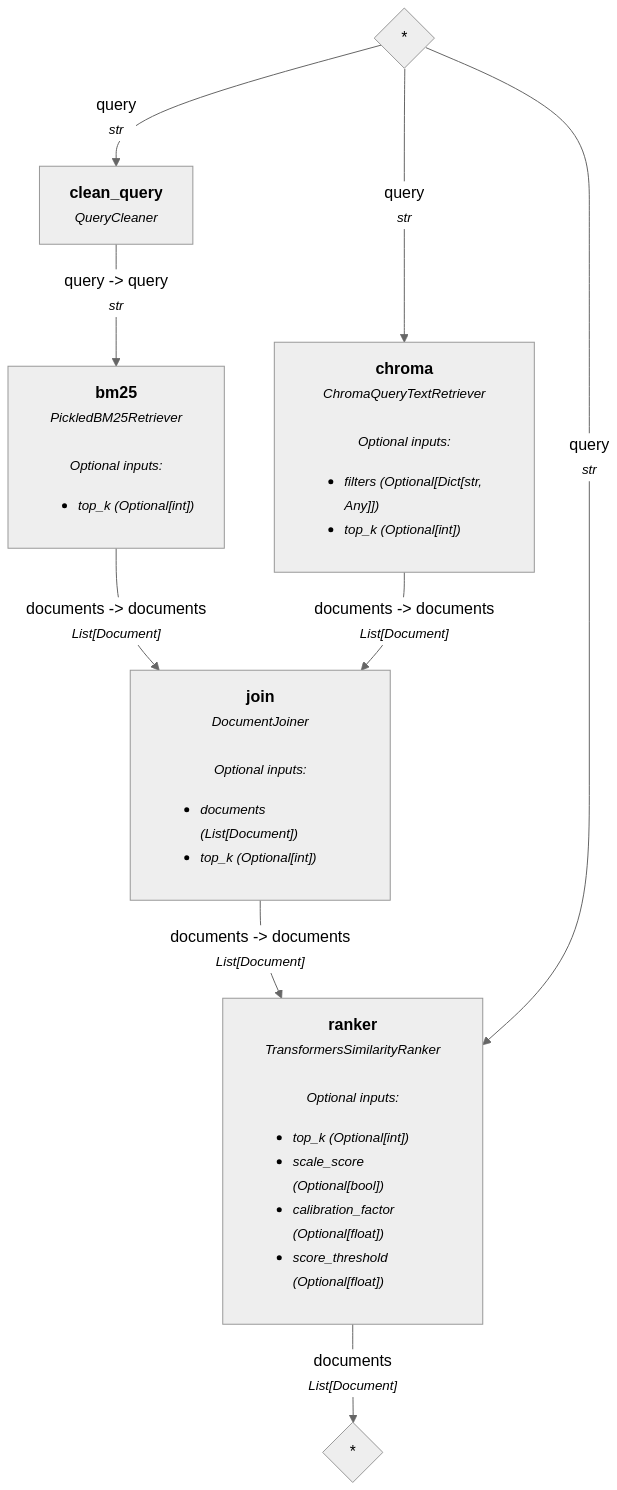

In [12]:
pipeline.show()

In [13]:
query = "Как оформить, заявление? на отпуск!"

output = pipeline.run({
    "clean_query": {"query": query},   # для bm25
    "chroma":     {"query": query},   # оригинал для chroma
    "ranker":     {"query": query},   # оригинал для ранкера
})

print("Топ‑5 после merge + cross‑encoder ранжирования:")
for i, doc in enumerate(output["ranker"]["documents"], 1):
    name    = doc.meta.get("name") or doc.id
    snippet = doc.content.replace("\n", " ")[:200]
    print(f"{i}. {name} — {snippet!r}")

Топ‑5 после merge + cross‑encoder ранжирования:
1. 24dc6f50624045ad368fa794536f878efd31dc191739232e5086d990d2e3c9bf — '{ "company": { "name": "ОАО \\"Крон-Ц\\"" }, "name": "Ежегодный оплачиваемый отпуск (не по графику с автоприказом)", "group": "Ежегодный оплачиваемый отпуск (не по графику с автоприказом)", "participant'
2. 07ec03291c2d3eac35a0a2a80128114f7e5de40ec50453f8ca8d118aa637d57e — 'тех пор она так и используется активно ребятами! Ведь по оформлению бага столько разных статей, ну разве удержишь это все в голове? А тут единый списочек. Так сказать, чек-лист заведения бага! О Пойми'
3. fbb3bed236177059b48f62061beab3ceb935a96e499fd67bc375369e1fc6a9c1 — 'обеспечивает их лучшее распределение и кон\xad троль ОГ особенно на переходных режимах. Недостатком некоторых вариантов РФК явля\xad ется ухудшенное смесеобразование. На час\xad тичных нагрузках ограниченное д'
4. 55b692e3cf062640fdbf57bf5566441a8097bcccb4d9577e9df82dd430692f75 — ',,,, ,,,, ,,,, "Информационные сервисы работника Ль

In [ ]:
prompt_builder = PromptBuilder(
    template_messages=[
        {"role": "system", "content": "Ты — помощник по базе знаний. Используй предоставленный контекст для ответа."},
        {"role": "user",   "content": "{{ query }}\n\nКонтекст:\n{{ context }}\n\nОтвет:"}
    ],
    output_var="prompts"
)

In [ ]:
pipe = Pipeline()

# 2.1 Классификация
pipe.add_component("classifier", QueryClassifierLLM(generator=llm))
# Разветвляем в два потока: no_search и to_search
pipe.add_component("router1", ConditionalRouter(routes=[
    {
      "condition"  : "{{ classifier.need_search == false }}",
      "output"     : "{{ query }}",
      "output_name": "no_search",
      "output_type": str
    },
    {
      "condition"  : "{{ classifier.need_search == true }}",
      "output"     : "{{ query }}",
      "output_name": "to_search",
      "output_type": str
    }
]))

# 2.2 Ветвь без поиска → прямой генератор
pipe.add_component("gen_direct", llm)
pipe.connect("router1.no_search", "gen_direct.query")

# 2.3 Ветвь поиска → декомпозер
pipe.add_component("decomposer", QueryDecomposerLLM(generator=llm))
pipe.connect("router1.to_search", "decomposer.query")

# 2.4 Второй роутер: разбивка или одиночный поиск
pipe.add_component("router2", ConditionalRouter(routes=[
    {
      "condition"  : "{{ decomposer.subqueries | length > 1 }}",
      "output"     : "{{ decomposer.subqueries }}",
      "output_name": "multi",
      "output_type": list[str]
    },
    {
      "condition"  : "{{ decomposer.subqueries | length <= 1 }}",
      "output"     : "{{ decomposer.subqueries[0] }}",
      "output_name": "single",
      "output_type": str
    }
]))
pipe.connect("decomposer.subqueries", "router2.subqueries")

# 2.5 Ветвь одиночного поиска: hybrid → ranker → prompt → gen
pipe.add_component("bm25", PickledBM25Retriever(path_to_pickle="data/bm25.pkl"))
pipe.add_component("chroma", chroma_retriever)
pipe.add_component("hybrid", HybridRetriever(bm25_retriever=pipe.get_component("bm25"),
                                             chroma_retriever=pipe.get_component("chroma")))
pipe.add_component("ranker", ranker)
pipe.add_component("prompt", prompt_builder)
pipe.connect("router2.single", "hybrid.query")
pipe.connect("hybrid.documents", "ranker.documents")
pipe.connect("ranker.documents",  "prompt.documents")
pipe.connect("router2.single", "prompt.query")
pipe.add_component("gen_single", llm)
pipe.connect("prompt.prompts",   "gen_single.query")

# 2.6 Ветвь мульти‑поиска: custom‑компонент, делающий loop + суммари
@component
class MultiQueryHandler:
    @component.output_types(answer=str)
    def __init__(self, hybrid, ranker, prompt_builder, generator):
        self.hybrid = hybrid
        self.ranker = ranker
        self.pb      = prompt_builder
        self.gen     = generator

    def run(self, multi: List[str], to_search: str) -> Dict[str, str]:
        answers = []
        # По каждому subquery
        for sq in multi:
            docs = self.ranker.run(documents=self.hybrid.run(query=sq)["documents"])["documents"]
            prompts = self.pb.run(query=sq, documents=docs)["prompts"]
            resp = self.gen.run([ChatMessage.from_user(prompts[0])])
            answers.append(resp["replies"][0].text)
        # Суммаризация
        summary_prompt = (
            f"На основе следующих ответов на части вопроса '{to_search}' "
            "объедини их в один связный ответ:\n" +
            "\n".join(f"Часть {i+1}: {a}" for i, a in enumerate(answers))
        )
        sum_msg  = ChatMessage.from_user(summary_prompt)
        sum_resp = self.gen.run([sum_msg])
        return {"answer": sum_resp["replies"][0].text}

multi_handler = MultiQueryHandler(
    hybrid=pipe.get_component("hybrid"),
    ranker=pipe.get_component("ranker"),
    prompt_builder=pipe.get_component("prompt"),
    generator=llm
)
pipe.add_component("multi_handler", multi_handler)
pipe.connect("router2.multi",  "multi_handler.multi")
pipe.connect("router1.to_search", "multi_handler.to_search")

# 2.7 Определяем финальный выход
# из gen_direct и gen_single + multi_handler.answer
pipe.add_output("answer", ["gen_direct.replies",        # прямой ответ
                           "gen_single.replies",        # одиночный RAG
                           "multi_handler.answer"       # множественный RAG+суммари
                          ])